In [ ]:
# --- Colab installs (GPU optional) ---
!pip -q install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu121
!pip -q install numpy pandas scikit-learn einops tqdm
!pip -q install kagglehub tensorflow

import os, math, random, glob
from dataclasses import dataclass
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.metrics import average_precision_score, precision_recall_curve

def set_seed(seed=1337):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed(1337)

device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_cuda = torch.cuda.is_available()
print("Device:", device)


Device: cpu


In [ ]:
import kagglehub

path = kagglehub.dataset_download("fantineh/next-day-wildfire-spread")
print("Dataset path:", path)

tfrecs = sorted(glob.glob(os.path.join(path, "*.tfrecord")))
print("TFRecord files found:", len(tfrecs))
print("\n".join(os.path.basename(p) for p in tfrecs[:10]))
assert len(tfrecs) > 0, "No TFRecords found."


100%|██████████| 2.08G/2.08G [00:27<00:00, 80.1MB/s]

Extracting files...


Dataset path: /root/.cache/kagglehub/datasets/fantineh/next-day-wildfire-spread/versions/2
TFRecord files found: 19
next_day_wildfire_spread_eval_00.tfrecord
next_day_wildfire_spread_eval_01.tfrecord
next_day_wildfire_spread_test_00.tfrecord
next_day_wildfire_spread_test_01.tfrecord
next_day_wildfire_spread_train_00.tfrecord
next_day_wildfire_spread_train_01.tfrecord
next_day_wildfire_spread_train_02.tfrecord
next_day_wildfire_spread_train_03.tfrecord
next_day_wildfire_spread_train_04.tfrecord
next_day_wildfire_spread_train_05.tfrecord


In [ ]:
# Fast converter for 64x64 float_list TFRecords
import tensorflow as tf

dst_root = "/content/wildfire_npz_tiles_kaggle_v3"
os.makedirs(dst_root, exist_ok=True)

# Known feature keys (all are float_list of length 4096)
keys = ['tmmn','NDVI','FireMask','population','elevation','vs','pdsi','pr','tmmx','sph','th','PrevFireMask','erc']

def read_flat_float32(feat):
    # feat is a tf.train.Feature
    fl = feat.float_list.value
    if len(fl) == 0:
        return None
    arr = np.asarray(fl, dtype=np.float32)
    if arr.size == 4096:
        return arr.reshape(64,64)
    s = int(round(math.sqrt(arr.size)))
    assert s*s == arr.size, f"Unexpected length {arr.size}"
    return arr.reshape(s, s)

def wind_uv(vs, th):
    th_rad = th.copy()
    if np.nanmax(th_rad) > 6.4:      # degrees → radians
        th_rad = np.deg2rad(th_rad % 360.0)
    u = vs * np.cos(th_rad); v = vs * np.sin(th_rad)
    return u.astype(np.float32), v.astype(np.float32)

def slope_aspect_from_elevation(z):
    gy, gx = np.gradient(z.astype(np.float32))
    mag = np.sqrt(gx**2 + gy**2)
    q95 = np.percentile(mag, 95) + 1e-6
    slope  = np.clip(mag / q95, 0, 1).astype(np.float32)
    aspect = np.arctan2(-gy, -gx).astype(np.float32)  # [-pi, pi]
    return slope, aspect

def rh_proxy_from_sph(sph, tmmn, tmmx):
    s95 = np.percentile(sph, 95) + 1e-6
    rh = np.clip(sph / s95, 0, 1)
    tr = np.clip((tmmx - tmmn), 0, 30) / 30.0
    rh = np.clip(rh * (1.0 - 0.5*tr), 0, 1).astype(np.float32)
    return rh

def barrier_from_population(pop):
    pop = np.clip(pop, 0, None).astype(np.float32)
    thr = np.percentile(pop, 90)
    return (pop >= thr).astype(np.float32)

converted = 0
for f in tqdm(tfrecs, desc="Converting (64x64 float_list)"):
    for raw in tf.data.TFRecordDataset(f):
        ex = tf.train.Example.FromString(raw.numpy()).features.feature

        # read all needed arrays
        A = {k: read_flat_float32(ex[k]) if k in ex else None for k in keys}
        if A["PrevFireMask"] is None or A["FireMask"] is None:
            continue  # skip broken record

        prev_fire = (A["PrevFireMask"] > 0.5).astype(np.float32)
        next_fire = (A["FireMask"]    > 0.5).astype(np.float32)
        tmmn = A["tmmn"] if A["tmmn"] is not None else np.full((64,64), 290, np.float32)
        tmmx = A["tmmx"] if A["tmmx"] is not None else np.full((64,64), 300, np.float32)
        temp = ((tmmn + tmmx)/2.0).astype(np.float32)

        vs = A["vs"] if A["vs"] is not None else np.zeros((64,64), np.float32)
        th = A["th"] if A["th"] is not None else np.zeros((64,64), np.float32)
        u, v = wind_uv(vs, th)

        ndvi = A["NDVI"] if A["NDVI"] is not None else np.full((64,64), 0.5, np.float32)
        if ndvi.min() < 0:  # map [-1,1] → [0,1]
            ndvi = np.clip((ndvi + 1.0)/2.0, 0, 1).astype(np.float32)

        sph = A["sph"] if A["sph"] is not None else np.zeros((64,64), np.float32)
        rh = rh_proxy_from_sph(sph, tmmn, tmmx)

        elev = A["elevation"] if A["elevation"] is not None else np.zeros((64,64), np.float32)
        slope, aspect = slope_aspect_from_elevation(elev)

        pop = A["population"] if A["population"] is not None else np.zeros((64,64), np.float32)
        barrier = barrier_from_population(pop)

        fields = dict(
            prev_fire=prev_fire, next_fire=next_fire,
            u=u, v=v, temp=temp, rh=rh, ndvi=ndvi,
            slope=slope, aspect=aspect, barrier=barrier
        )

        sid_feat = ex.get("sample_id", None)
        if sid_feat and len(sid_feat.bytes_list.value) > 0:
            sid = sid_feat.bytes_list.value[0].decode("utf-8")
        else:
            sid = f"{os.path.basename(f)}_{converted:07d}"

        np.savez(os.path.join(dst_root, f"{sid}.npz"), **fields)
        converted += 1

print(f"Converted {converted} tiles → {dst_root}")

# quick sanity check
npzs = sorted(glob.glob(os.path.join(dst_root, "*.npz")))
print("NPZ files:", len(npzs))
if npzs:
    samp = np.load(npzs[0])
    print("Sample keys:", list(samp.keys()), "| shape:", samp["prev_fire"].shape)


Converting (64x64 float_list):   0%|          | 0/19 [00:00<?, ?it/s]

Converted 18545 tiles → /content/wildfire_npz_tiles_kaggle_v3
NPZ files: 18545
Sample keys: ['prev_fire', 'next_fire', 'u', 'v', 'temp', 'rh', 'ndvi', 'slope', 'aspect', 'barrier'] | shape: (64, 64)


In [ ]:
@dataclass
class WildfirePaths:
    root: str

class WildfireDataset(Dataset):
    def __init__(self, paths:WildfirePaths, split="train", max_samples=None, seed=1337):
        self.paths = paths
        all_files = sorted(glob.glob(os.path.join(paths.root, "*.npz")))
        if len(all_files) == 0:
            raise ValueError(f"No .npz files in {paths.root}")
        rng = np.random.default_rng(seed); rng.shuffle(all_files)
        n = len(all_files); n_train = int(round(0.70*n)); n_val = int(round(0.15*n))
        if split == "train":
            sel = np.arange(0, max(1,n_train))
        elif split == "val":
            sel = np.arange(n_train, max(n_train+1, n_train+n_val))
        elif split == "test":
            sel = np.arange(n_train+n_val, n) if (n_train+n_val)<n else np.arange(n-1,n)
        else:
            raise ValueError("split must be train|val|test")
        files = [all_files[i] for i in sel]
        if max_samples: files = files[:max_samples]
        if len(files)==0: files=[all_files[0]]
        self.files = files

    def __len__(self): return len(self.files)

    def __getitem__(self, i):
        arr = np.load(self.files[i])
        required = ["prev_fire","next_fire","u","v","temp","rh","ndvi","slope","aspect"]
        missing = [k for k in required if k not in arr]
        if missing:
            raise KeyError(f"{os.path.basename(self.files[i])} missing keys: {missing}")
        prev_fire = arr["prev_fire"][None,...].astype(np.float32)
        next_fire = arr["next_fire"][None,...].astype(np.float32)
        u   = arr["u"][None,...].astype(np.float32)
        v   = arr["v"][None,...].astype(np.float32)
        temp= arr["temp"][None,...].astype(np.float32)
        rh  = arr["rh"][None,...].astype(np.float32)
        ndvi= arr["ndvi"][None,...].astype(np.float32)
        slope = arr["slope"][None,...].astype(np.float32)
        aspect= arr["aspect"][None,...].astype(np.float32)
        barrier = (arr["barrier"][None,...].astype(np.float32)
                   if "barrier" in arr else np.zeros_like(prev_fire))
        X_raw = np.concatenate([prev_fire,u,v,temp,rh,ndvi,slope,aspect,barrier], axis=0)
        y = next_fire
        return {"X_raw": torch.from_numpy(X_raw), "y": torch.from_numpy(y)}


In [ ]:
class PhysicsPrior(nn.Module):
    def __init__(self, kernel_radius=3):
        super().__init__()
        self.kernel_radius = kernel_radius
        self.register_buffer("angle_grid", self._make_angle_grid(kernel_radius))
    @staticmethod
    def _make_angle_grid(r):
        yy, xx = torch.meshgrid(torch.arange(-r, r+1), torch.arange(-r, r+1), indexing='ij')
        return torch.atan2(yy.float(), xx.float()+1e-8)
    def forward(self, prev_fire, u, v, slope, aspect, T, RH, NDVI, barrier=None):
        B, _, H, W = prev_fire.shape
        wind_angle = torch.atan2(v, u + 1e-8)
        wind_speed = torch.sqrt(u**2 + v**2)
        ws_norm = torch.clamp(wind_speed / 10.0, 0, 1)
        slope_norm = torch.clamp(slope, 0, 1)
        r = self.kernel_radius; K = 2*r + 1
        ang_flat = self.angle_grid.view(1,1,K*K,1,1).to(prev_fire)
        wa  = wind_angle.unsqueeze(2); asp = aspect.unsqueeze(2)
        aw  = (1.0 * ws_norm).unsqueeze(2)
        as_ = (1.0 * slope_norm).unsqueeze(2)
        dtheta_w = ang_flat - wa; dtheta_s = ang_flat - asp
        Ww = torch.exp(aw * torch.cos(dtheta_w))
        Ws = torch.exp(as_ * torch.cos(dtheta_s))
        kernel_flat = Ww * Ws
        kernel_flat = kernel_flat / (kernel_flat.sum(dim=2, keepdim=True) + 1e-8)
        ker = kernel_flat.reshape(B, K*K, H*W)
        pf_unf = F.unfold(prev_fire, kernel_size=K, padding=r)
        P1 = (pf_unf * ker).sum(dim=1).view(B,1,H,W)
        a0, a1, a2, a3 = 0.0, 0.04, 0.03, 0.8
        Damp = torch.sigmoid(a0 + a1*T - a2*RH + a3*NDVI)
        P = P1 * Damp
        if barrier is not None: P = P * (1.0 - barrier.clamp(0,1))
        Wx = torch.cos(wind_angle); Wy = torch.sin(wind_angle)
        return torch.cat([P, Wx, Wy, Damp], dim=1)

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch), nn.SiLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch), nn.SiLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class UNet(nn.Module):
    def __init__(self, in_ch, out_ch=1, base=64):
        super().__init__()
        self.down1 = DoubleConv(in_ch, base);   self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(base, base*2);  self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(base*2, base*4);self.pool3 = nn.MaxPool2d(2)
        self.bottom= DoubleConv(base*4, base*8)
        self.up3   = nn.ConvTranspose2d(base*8, base*4, 2, 2)
        self.conv3 = DoubleConv(base*8, base*4)
        self.up2   = nn.ConvTranspose2d(base*4, base*2, 2, 2)
        self.conv2 = DoubleConv(base*4, base*2)
        self.up1   = nn.ConvTranspose2d(base*2, base, 2, 2)
        self.conv1 = DoubleConv(base*2, base)
        self.outc  = nn.Conv2d(base, out_ch, 1)
    def forward(self, x):
        x1 = self.down1(x)
        x2 = self.down2(self.pool1(x1))
        x3 = self.down3(self.pool2(x2))
        xb = self.bottom(self.pool3(x3))
        x  = self.up3(xb); x = self.conv3(torch.cat([x, x3], dim=1))
        x  = self.up2(x);  x = self.conv2(torch.cat([x, x2], dim=1))
        x  = self.up1(x);  x = self.conv1(torch.cat([x, x1], dim=1))
        return self.outc(x)

class FocalLoss(nn.Module):
    def __init__(self, gamma=1.5, alpha=0.5, reduction="mean"):
        super().__init__(); self.gamma, self.alpha, self.reduction = gamma, alpha, reduction
    def forward(self, logits, targets):
        p = torch.sigmoid(logits)
        ce = F.binary_cross_entropy_with_logits(logits, targets, reduction="none")
        p_t = p*targets + (1-p)*(1-targets)
        loss = ((1-p_t)**self.gamma) * ce
        alpha_t = self.alpha*targets + (1-self.alpha)*(1-targets)
        loss = alpha_t * loss
        return loss.mean() if self.reduction=="mean" else loss.sum()

class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1.0): super().__init__(); self.smooth = smooth
    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        dims = (0,2,3)
        inter = (probs*targets).sum(dims)
        denom = probs.sum(dims) + targets.sum(dims)
        dice = (2*inter + self.smooth) / (denom + self.smooth)
        return 1 - dice.mean()

class FocalTverskyLoss(nn.Module):
    def __init__(self, alpha=0.7, beta=0.3, gamma=0.75, smooth=1.0):
        super().__init__()
        self.alpha, self.beta, self.gamma, self.smooth = alpha, beta, gamma, smooth
    def forward(self, logits, targets):
        p = torch.sigmoid(logits)
        dims = (0,2,3)
        TP = (p*targets).sum(dims)
        FP = (p*(1-targets)).sum(dims)
        FN = ((1-p)*targets).sum(dims)
        T = (TP + self.smooth) / (TP + self.alpha*FP + self.beta*FN + self.smooth)
        return (1 - T).pow(self.gamma).mean()


In [ ]:
# --- point to the Kaggle-converted tiles ---
data_root = "/content/wildfire_npz_tiles_kaggle_v3"

train_ds = WildfireDataset(WildfirePaths(data_root), split="train", max_samples=1200)
val_ds   = WildfireDataset(WildfirePaths(data_root),   split="val",   max_samples=300)
test_ds  = WildfireDataset(WildfirePaths(data_root),   split="test",  max_samples=300)

# --- per-channel stats on the 9 original raw channels ---
@torch.no_grad()
def compute_channel_stats(ds, n_max=None):
    sums = np.zeros(9, dtype=np.float64); sqs = np.zeros(9, dtype=np.float64); count = 0
    loader = DataLoader(ds, batch_size=32, shuffle=False, num_workers=0)
    for i, b in enumerate(loader):
        x = b["X_raw"].numpy()  # (B,9,H,W)
        B,C,H,W = x.shape
        x = x.reshape(B, C, -1)
        sums += x.sum(axis=(0,2)); sqs += (x**2).sum(axis=(0,2)); count += B*H*W
        if n_max and (i+1)*B >= n_max: break
    mean = sums / count
    var  = sqs / count - mean**2
    std  = np.sqrt(np.maximum(var, 1e-8))
    std[[0,8]] = 1.0  # don't normalize prev_fire & barrier
    return torch.tensor(mean, dtype=torch.float32), torch.tensor(std, dtype=torch.float32)

mean9, std9 = compute_channel_stats(train_ds)
mean9, std9 = mean9.to(device), std9.to(device)

# --- CPU-safe DataLoaders with upweighting for positive tiles ---
def make_loader(ds, batch_size=16, upweight_positive=False, shuffle=False):
    if upweight_positive:
        weights = []
        for f in ds.files:
            y = np.load(f)["next_fire"]
            weights.append(5.0 if y.sum() > 0 else 1.0)
        sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)
        return DataLoader(ds, batch_size=batch_size, sampler=sampler,
                          num_workers=0, pin_memory=use_cuda, persistent_workers=False)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle,
                      num_workers=0, pin_memory=use_cuda, persistent_workers=False)

train_loader = make_loader(train_ds, batch_size=16, upweight_positive=True)
val_loader   = make_loader(val_ds,   batch_size=16, upweight_positive=False, shuffle=False)
test_loader  = make_loader(test_ds,  batch_size=16, upweight_positive=False, shuffle=False)

# --- geometry-aware augmentation on RAW channels ---
def aug_geo(X_raw, y):
    # X_raw order: [prev, u, v, temp, rh, ndvi, slope, aspect(rad), barrier]
    if torch.rand(1).item() < 0.5:
        X_raw = torch.flip(X_raw, dims=[-1]); y = torch.flip(y, dims=[-1])
        X_raw[:,1] = -X_raw[:,1]
        X_raw[:,7] = torch.atan2(torch.sin(X_raw[:,7]), -torch.cos(X_raw[:,7]))  # pi - aspect
    if torch.rand(1).item() < 0.5:
        X_raw = torch.flip(X_raw, dims=[-2]); y = torch.flip(y, dims=[-2])
        X_raw[:,2] = -X_raw[:,2]
        X_raw[:,7] = -X_raw[:,7]
    k = torch.randint(0,4,(1,)).item()
    if k>0:
        X_raw = torch.rot90(X_raw, k, dims=[-2,-1]); y = torch.rot90(y, k, dims=[-2,-1])
        u,v,asp = X_raw[:,1].clone(), X_raw[:,2].clone(), X_raw[:,7].clone()
        if   k==1: X_raw[:,1], X_raw[:,2], X_raw[:,7] = -v,  u,  asp+math.pi/2
        elif k==2: X_raw[:,1], X_raw[:,2], X_raw[:,7] = -u, -v,  asp+math.pi
        elif k==3: X_raw[:,1], X_raw[:,2], X_raw[:,7] =  v, -u,  asp-math.pi/2
        X_raw[:,7] = ((X_raw[:,7]+math.pi) % (2*math.pi)) - math.pi
    return X_raw, y

# --- prior, model, loss, optimizer, scheduler ---
prior = PhysicsPrior(kernel_radius=3).to(device)

# 9 raw (norm) + 3 derived (cos(aspect), sin(aspect), wind speed) + 4 prior = 16
model = UNet(in_ch=16, out_ch=1, base=64).to(device)

loss_fn = lambda logits, y: (
    0.5 * FocalLoss(gamma=1.5, alpha=0.5)(logits, y)
  + 0.5 * FocalTverskyLoss(alpha=0.6, beta=0.4, gamma=0.75)(logits, y)
)

EPOCHS = 15  # try 30–40 once steady
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=5e-5)

def build_input_for_net(X_raw0):
    # split RAW tensors
    pf0,u0,v0,T0,RH0,NDVI0,sl0,asp0,bar0 = \
        X_raw0[:,0:1],X_raw0[:,1:2],X_raw0[:,2:3],X_raw0[:,3:4],X_raw0[:,4:5], \
        X_raw0[:,5:6],X_raw0[:,6:7],X_raw0[:,7:8],X_raw0[:,8:9]
    # derived (from RAW)
    asp_cos = torch.cos(asp0)
    asp_sin = torch.sin(asp0)
    ws      = torch.clamp(torch.sqrt(u0**2 + v0**2)/10.0, 0, 1)
    # normalize the 9 originals
    X9_norm = (X_raw0 - mean9.view(1,-1,1,1)) / std9.view(1,-1,1,1)
    # physics features (RAW)
    with torch.no_grad():
        X_phys = prior(pf0,u0,v0,sl0,asp0,T0,RH0,NDVI0,bar0)
    # concat: 16 channels
    return torch.cat([X9_norm, asp_cos, asp_sin, ws, X_phys], dim=1)

def train_one_epoch(model, loader, optim):
    model.train(); prior.eval()
    losses = []
    for batch in tqdm(loader, desc="train", leave=False):
        X_raw0, y = batch["X_raw"].to(device), batch["y"].to(device)
        # geometry-aware aug on RAW tensors
        X_raw0, y = aug_geo(X_raw0, y)
        X = build_input_for_net(X_raw0)
        logits = model(X)
        loss = loss_fn(logits, y)
        optim.zero_grad(); loss.backward(); optim.step()
        losses.append(loss.item())
    return float(np.mean(losses))

@torch.no_grad()
def evaluate(model, loader):
    model.eval(); prior.eval()
    all_probs, all_true = [], []
    for batch in tqdm(loader, desc="eval", leave=False):
        X_raw0, y = batch["X_raw"].to(device), batch["y"].to(device)
        X = build_input_for_net(X_raw0)
        probs = torch.sigmoid(model(X)).cpu().numpy()
        all_probs.append(probs.ravel()); all_true.append(y.cpu().numpy().ravel())
    p = np.concatenate(all_probs); t = np.concatenate(all_true)
    if t.sum()==0: return 0.0, 0.0
    ap = average_precision_score(t, p)
    prec, rec, thr = precision_recall_curve(t, p)
    f1 = (2*prec*rec)/(prec+rec+1e-8)
    return float(ap), float(f1.max())

# --- train ---
best_val_ap = -1.0
for epoch in range(EPOCHS):
    tr = train_one_epoch(model, train_loader, optimizer)
    ap, f1 = evaluate(model, val_loader)
    print(f"Epoch {epoch:02d} | loss {tr:.4f} | val AP {ap:.4f} | val F1* {f1:.4f}")
    if ap > best_val_ap:
        best_val_ap = ap
        torch.save({"model": model.state_dict()}, "/content/best_unet.pt")
    scheduler.step()
print("Best val AP:", best_val_ap)

# --- test ---
ckpt = torch.load("/content/best_unet.pt", map_location=device)
model.load_state_dict(ckpt["model"])
test_ap, test_f1 = evaluate(model, test_loader)
print(f"TEST: AP={test_ap:.4f} | Best-F1≈{test_f1:.4f}")


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 00 | loss 0.5364 | val AP 0.0792 | val F1* 0.2130


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 01 | loss 0.5193 | val AP 0.1711 | val F1* 0.3072


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 02 | loss 0.5113 | val AP 0.1700 | val F1* 0.3050


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 03 | loss 0.5067 | val AP 0.1857 | val F1* 0.3202


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 04 | loss 0.5014 | val AP 0.1947 | val F1* 0.3249


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 05 | loss 0.4988 | val AP 0.2027 | val F1* 0.3293


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 06 | loss 0.4961 | val AP 0.1880 | val F1* 0.3248


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 07 | loss 0.4933 | val AP 0.2093 | val F1* 0.3294


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 08 | loss 0.4922 | val AP 0.2182 | val F1* 0.3342


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 09 | loss 0.4901 | val AP 0.2140 | val F1* 0.3344


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 10 | loss 0.4899 | val AP 0.2207 | val F1* 0.3340


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 11 | loss 0.4867 | val AP 0.2205 | val F1* 0.3369


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 12 | loss 0.4853 | val AP 0.2147 | val F1* 0.3390


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 13 | loss 0.4843 | val AP 0.2347 | val F1* 0.3478


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 14 | loss 0.4794 | val AP 0.2432 | val F1* 0.3512
Best val AP: 0.24319519537340498


eval:   0%|          | 0/19 [00:00<?, ?it/s]

TEST: AP=0.2713 | Best-F1≈0.3608


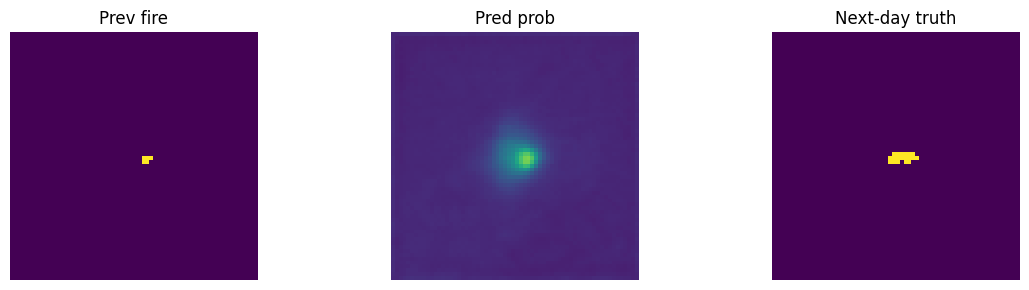

In [ ]:
import matplotlib.pyplot as plt
@torch.no_grad()
def show_one(ds, i=0):
    b = ds[i]
    X_raw0 = b["X_raw"].unsqueeze(0).to(device)
    y = b["y"][0].numpy()
    X = build_input_for_net(X_raw0)
    prob = torch.sigmoid(model(X))[0,0].cpu().numpy()
    fig,axs = plt.subplots(1,3, figsize=(12,3))
    axs[0].imshow(b["X_raw"][0], vmin=0, vmax=1); axs[0].set_title("Prev fire")
    axs[1].imshow(prob, vmin=0, vmax=1);          axs[1].set_title("Pred prob")
    axs[2].imshow(y, vmin=0, vmax=1);             axs[2].set_title("Next-day truth")
    for a in axs: a.axis('off')
    plt.tight_layout(); plt.show()

show_one(test_ds, i=0)
